In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import fetch_lfw_people
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

Best estimator found by grid search:
SVC(C=31271.093952068186, class_weight='balanced', gamma=0.0034491425183061438)
                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.77      0.80        13
     Colin Powell       0.81      0.90      0.85        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.88      0.95      0.91       146
Gerhard Schroeder       0.91      0.80      0.85        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.94      0.83      0.88        36

         accuracy                           0.87       322
        macro avg       0.87      0.78      0.81       322
     weighted avg       0.87      0.87      0.86       322



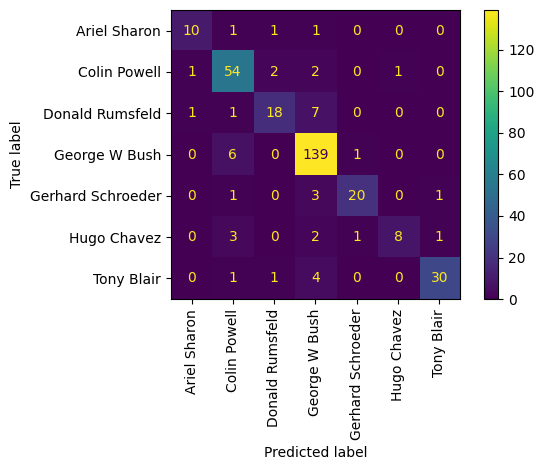

In [21]:
# 加载数据集
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
target_names = lfw_people.target_names
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# PCA降维
n_components = 150
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# 训练SVM模型
param_grid = {
    "C": loguniform(1e-3, 1e6),  # 软间隔的损失
    "gamma": loguniform(1e-4, 1e-1),    # 硬间隔的gamma参数
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=20
)
clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

# 预测
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [20]:
# 要使用matplotlib对预测结果进行定性评估
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

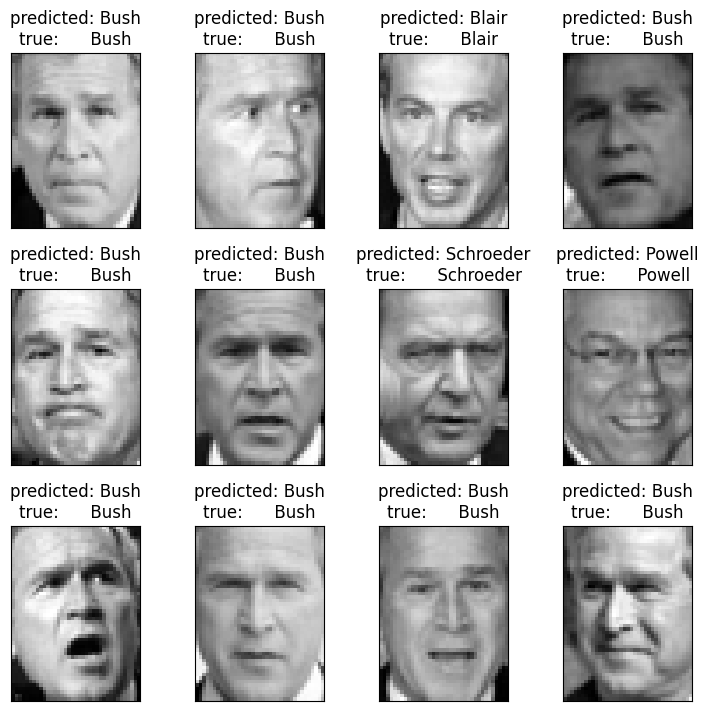

In [21]:
# 绘制模型在测试集的一个子集上的预测结果
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

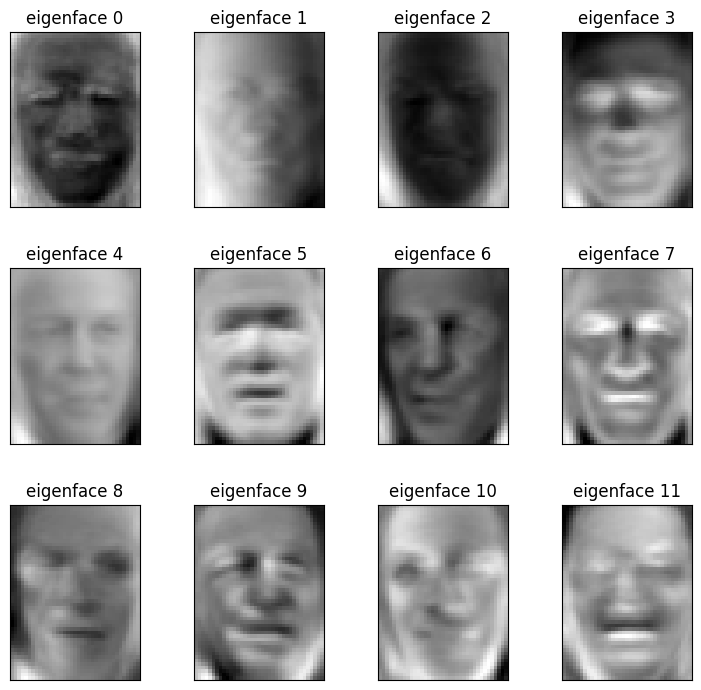

In [22]:
# 绘制最显著的特征脸（eigenfaces）

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()